# FlOWR.root Tutorial: Pocket-Conditional Ligand Generation and Affinity Prediction

This tutorial demonstrates how to use the **FLOWR.root** model for various ligand generation tasks:

1. **De Novo Generation** - Generate ligands from scratch for a protein pocket
2. **Scaffold-Conditional Generation** - Generate ligands preserving a molecular scaffold
3. **Functional Group-Conditional Generation** - Generate ligands preserving specific functional groups
4. **Substructure Inpainting** - Regenerate specific parts of a ligand while preserving others
5. **Affinity Prediction** - Predict binding affinities for generated ligands

## 1. Setup and Configuration

First, let's import the required libraries and define our global configuration variables.

In [1]:
# Import required libraries
import subprocess
import glob
from pathlib import Path
from typing import Union, List, Optional

# Molecular visualization and manipulation
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
import py3Dmol

# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, SVG

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [ ]:
# =============================================================================
#                         GLOBAL CONFIGURATION
# =============================================================================

# Target protein
TARGET = "ptCOORD_NOISE_STD = 0.1 # How much noise added to generation to increae diversity
POCKET_CUTOFF = 6 # Determines size of the pocket, in Angstrom
LIGAND_IDX = 0  # Reference ligand index for conditional generation if your SDF contains several ligands, otherwise ignore
N_MOLECULES = 5  # Number of molecules to generate
BATCH_COST = 20 # Modify depending on your compute to avoud out-of-memory errors (SET TO 1 or 2 IF YOU RUN THIS LOCALLY ON A MAC!)
NUM_GPUS = 1 # NVIDIA GPU with at least 40GB VRAM recommended (otherwise reduce BATCH_COST)
NUM_WORKERS = 12 # Number of CPU workers for data loading (SET TO 0 IF YOU RUN THIS LOCALLY ON A MAC!)p1b"

# Paths
EXAMPLES_DIR = "/home/user/flowr_root"

# Input files
PROTEIN_PDB = "/home/user/flowr_root/examples/cdk2_protein.pdb"
LIGANDS_SDF = "/home/user/flowr_root/examples/cdk2_ligands.sdf"

# Model checkpoint - UPDATE THIS PATH!
CKPT_PATH = "/home/user/flowr_root_v2.ckpt"

# Output base directory
SAVE_DIR = "/home/user/flowr_root/out"

# Generation parameters


print(f"{'='*60}")
print("   FlOWR.root Tutorial Configuration")
print(f"{'='*60}")
print(f"  Target:           {TARGET.upper()}")
print(f"  Protein PDB:      {PROTEIN_PDB}")
print(f"  Ligands SDF:      {LIGANDS_SDF}")
print(f"  Checkpoint:       {CKPT_PATH}")
print(f"  Output directory: {SAVE_DIR}")
print(f"  Reference ligand: index {LIGAND_IDX}")
print(f"  Molecules/target: {N_MOLECULES}")
print(f"{'='*60}")

   FlOWR.root Tutorial Configuration
  Target:           PTP1B
  Protein PDB:      /home/user/flowr_root/examples/cdk2_protein.pdb
  Ligands SDF:      /home/user/flowr_root/examples/cdk2_ligands.sdf
  Checkpoint:       /home/user/flowr_root_v2.ckpt
  Output directory: /home/user/flowr_root/out
  Reference ligand: index 0
  Molecules/target: 5


In [5]:
# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def load_molecules_from_sdf(sdf_path):
    """Load molecules from an SDF file."""
    supplier = Chem.SDMolSupplier(str(sdf_path), removeHs=False)
    mols = [mol for mol in supplier if mol is not None]
    print(f"Loaded {len(mols)} molecules from {sdf_path}")
    return mols


def visualize_molecules_2d(mols, legends=None, mols_per_row=4, img_size=(300, 300)):
    """Create a 2D grid visualization of molecules."""
    if legends is None:
        legends = [f"Mol {i+1}" for i in range(len(mols))]
    
    img = Draw.MolsToGridImage(
        mols, 
        molsPerRow=mols_per_row, 
        subImgSize=img_size,
        legends=legends
    )
    return img


def visualize_ligand_3d(mol, style='stick', width=600, height=400):
    """Visualize a single ligand in 3D using py3Dmol."""
    viewer = py3Dmol.view(width=width, height=height)
    
    # Convert mol to MolBlock
    mol_block = Chem.MolToMolBlock(mol)
    viewer.addModel(mol_block, 'mol')
    
    if style == 'stick':
        viewer.setStyle({'stick': {'colorscheme': 'greenCarbon'}})
    elif style == 'sphere':
        viewer.setStyle({'sphere': {'scale': 0.3}})
    
    viewer.zoomTo()
    return viewer


def visualize_ligand_in_pocket(ligand_mol, protein_pdb_path, width=800, height=600):
    """Visualize ligand within the protein pocket with enhanced styling."""
    viewer = py3Dmol.view(width=width, height=height)
    
    # Add protein
    with open(protein_pdb_path, 'r') as f:
        protein_data = f.read()
    viewer.addModel(protein_data, 'pdb')
    
    # Protein backbone as cartoon with spectrum coloring
    viewer.setStyle({'model': 0}, {
        'cartoon': {
            'color': 'spectrum',
            'opacity': 0.85,
            'thickness': 0.4
        }
    })
    
    # Highlight binding site residues (within 5Å of ligand)
    viewer.addStyle(
        {'model': 0, 'within': {'distance': 5, 'sel': {'model': 1}}},
        {
            'stick': {
                'colorscheme': 'whiteCarbon',
                'radius': 0.15
            }
        }
    )
    
    # Add transparent surface for binding pocket
    viewer.addSurface(
        py3Dmol.VDW,
        {
            'opacity': 0.25,
            'color': 'white',
            'wireframe': False
        },
        {'model': 0, 'within': {'distance': 6, 'sel': {'model': 1}}}
    )
    
    # Add ligand
    mol_block = Chem.MolToMolBlock(ligand_mol)
    viewer.addModel(mol_block, 'mol')
    
    # Ligand as ball-and-stick with vibrant colors
    viewer.setStyle({'model': 1}, {
        'stick': {
            'colorscheme': 'cyanCarbon',
            'radius': 0.2
        },
        'sphere': {
            'colorscheme': 'cyanCarbon',
            'scale': 0.25
        }
    })
    
    # Add labels for ligand atoms (optional - heavy atoms only)
    viewer.addLabel(
        "Ligand",
        {
            'fontSize': 12,
            'fontColor': 'white',
            'backgroundColor': 'rgba(0,150,150,0.7)',
            'backgroundOpacity': 0.7
        },
        {'model': 1, 'atom': 'C', 'serial': 1}
    )
    
    # Set background gradient
    viewer.setBackgroundColor('0xffffff', 0.9)
    
    # Zoom and center on ligand with padding
    viewer.zoomTo({'model': 1}, 200)
    
    # Add outline for depth perception
    viewer.setViewStyle({'style': 'outline', 'color': 'black', 'width': 0.02})
    
    return viewer


def visualize_multiple_ligands_in_pocket(ligand_mols, protein_pdb_path, width=800, height=600, 
                                          show_labels=True, show_surface=True):
    """Visualize multiple ligands within the protein pocket with enhanced styling."""
    viewer = py3Dmol.view(width=width, height=height)
    
    # Add protein
    with open(protein_pdb_path, 'r') as f:
        protein_data = f.read()
    viewer.addModel(protein_data, 'pdb')
    
    # Protein styling - prominent with spectrum coloring
    viewer.setStyle({'model': 0}, {
        'cartoon': {
            'color': 'spectrum',
            'opacity': 1.0,
            'thickness': 0.5,
            'arrows': True
        }
    })
    
    # Carbon colorscheme names available in py3Dmol
    carbon_schemes = [
        'greenCarbon',
        'cyanCarbon', 
        'magentaCarbon',
        'orangeCarbon',
        'purpleCarbon',
        'blueCarbon',
        'yellowCarbon',
        'whiteCarbon',
        'pinkCarbon',
        'grayCarbon',
    ]
    
    num_ligands = min(len(ligand_mols), 10)
    
    # Add ligands with element-based coloring
    for i, mol in enumerate(ligand_mols[:num_ligands]):
        mol_block = Chem.MolToMolBlock(mol)
        viewer.addModel(mol_block, 'mol')
        
        model_idx = i + 1
        scheme = carbon_schemes[i % len(carbon_schemes)]
        
        # Standard element coloring with unique carbon color per ligand
        viewer.setStyle({'model': model_idx}, {
            'stick': {
                'colorscheme': scheme,
                'radius': 0.2
            },
            'sphere': {
                'colorscheme': scheme,
                'scale': 0.25
            }
        })
        
        # Add labels for each ligand
        if show_labels:
            viewer.addLabel(
                f"Ligand {i + 1}",
                {
                    'fontSize': 11,
                    'fontColor': 'white',
                    'backgroundColor': 'gray',
                    'backgroundOpacity': 0.85,
                    'borderRadius': 4,
                    'padding': 2
                },
                {'model': model_idx, 'serial': 1}
            )
    
    # Add binding site residues
    for i in range(num_ligands):
        viewer.addStyle(
            {'model': 0, 'within': {'distance': 4.5, 'sel': {'model': i + 1}}},
            {
                'stick': {
                    'colorscheme': 'default',
                    'radius': 0.12
                }
            }
        )
    
    # Add colored transparent surface around binding pocket
    if show_surface and num_ligands > 0:
        viewer.addSurface(
            py3Dmol.SAS,
            {
                'opacity': 0.6,
                'color': '0x4682b4',
            },
            {'model': 0, 'within': {'distance': 7, 'sel': {'model': 1}}}
        )
    
    viewer.setBackgroundColor('0xf0f0f0')
    viewer.zoomTo()
    
    return viewer

def visualize_mol_with_atom_indices(mol, size=(500, 400)):
    """Draw molecule with atom indices labeled."""
    mol_copy = Chem.Mol(mol)
    AllChem.Compute2DCoords(mol_copy)
    
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    opts = drawer.drawOptions()
    opts.addAtomIndices = True
    
    drawer.DrawMolecule(mol_copy)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg))

def run_command(cmd, description=""):
    """Run a shell command and print output."""
    print(f"\n{'='*60}")
    print(f"Running: {description}")
    print(f"Command: {' '.join(cmd)}")
    print('='*60)
    
    result = subprocess.run(cmd, capture_output=True, text=True, cwd="/home/user/flowr_root")
    
    if result.returncode != 0:
        print(f"Error:\n{result.stderr}")
        raise RuntimeError(f"Command failed with return code {result.returncode}")
    
    print(result.stdout)
    print(f"✓ {description} completed successfully!")
    return result


print("✓ Helper functions defined!")

✓ Helper functions defined!


Loaded 16 molecules from /home/user/flowr_root/examples/cdk2_ligands.sdf

Reference ligands for PTP1B:


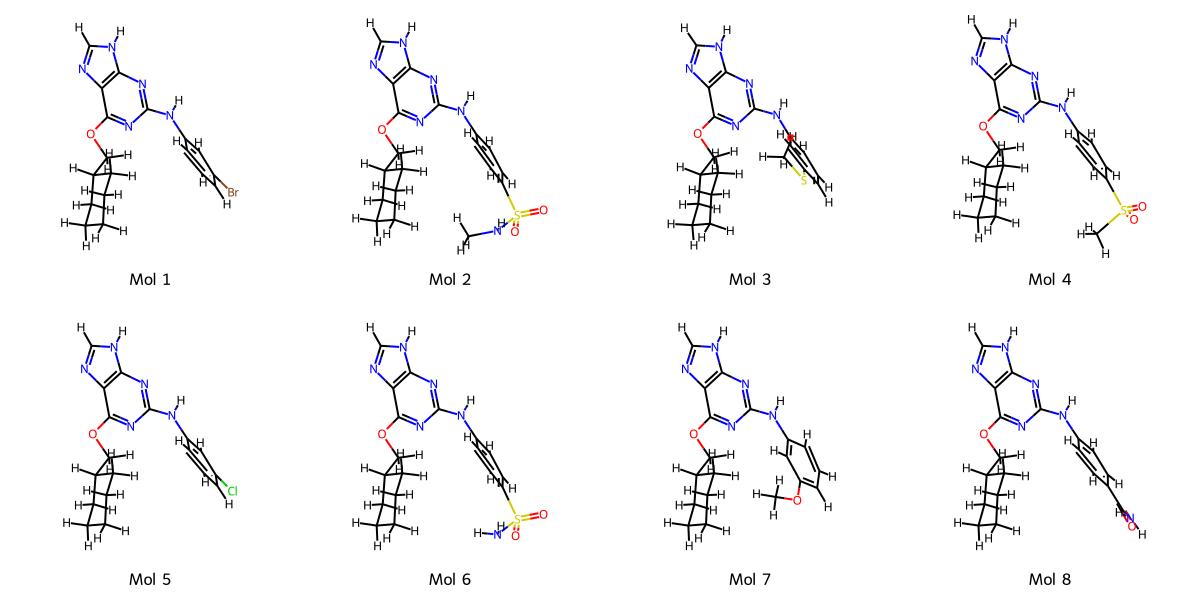

In [6]:
# Let's first examine the reference ligands in our dataset
ref_mols = load_molecules_from_sdf(LIGANDS_SDF)

# Display 2D structures
print(f"\nReference ligands for {TARGET.upper()}:")
visualize_molecules_2d(ref_mols[:8], mols_per_row=4)

## 2. De Novo Generation

De novo generation creates new ligands from scratch, using only the protein pocket structure as input. The model learns to generate molecules that are complementary to the binding site.

In [9]:
# =============================================================================
#                         DE NOVO GENERATION
# =============================================================================

DENOVO_SAVE_DIR = "/home/user/flowr_root/out/denovo"

denovo_cmd = [
    "python", "-m", "flowr.gen.generate_from_pdb",
    "--pdb_file", str(PROTEIN_PDB),
    "--ligand_file", str(LIGANDS_SDF),
    "--arch", "pocket",
    "--pocket_type", "holo",
    "--cut_pocket",
    "--pocket_cutoff", str(POCKET_CUTOFF),
    "--gpus", str(NUM_GPUS),
    "--batch_cost", str(BATCH_COST),
    "--num_workers", str(NUM_WORKERS),
    "--ckpt_path", str(CKPT_PATH),
    "--save_dir", str(DENOVO_SAVE_DIR),
    "--max_sample_iter", "20",
    "--coord_noise_scale", str(COORD_NOISE_STD),
    "--sample_n_molecules_per_target", str(N_MOLECULES),
    "--sample_mol_sizes",
    "--categorical_strategy", "uniform-sample",
    "--filter_valid_unique",
]

print("De Novo Generation Configuration:")
print(f"  Output: {DENOVO_SAVE_DIR}")
print(f"  N molecules: {N_MOLECULES}")
print(f"  Noise scale: {COORD_NOISE_STD}")

De Novo Generation Configuration:
  Output: /home/user/flowr_root/out/denovo
  N molecules: 5
  Noise scale: 0.1


In [10]:
# Run de novo generation
# This may take several minutes depending on your hardware
run_command(denovo_cmd, "De Novo Ligand Generation")


Running: De Novo Ligand Generation
Command: python -m flowr.gen.generate_from_pdb --pdb_file /home/user/flowr_root/examples/cdk2_protein.pdb --ligand_file /home/user/flowr_root/examples/cdk2_ligands.sdf --arch pocket --pocket_type holo --cut_pocket --pocket_cutoff 6 --gpus 1 --batch_cost 20 --num_workers 12 --ckpt_path /home/user/flowr_root_v2.ckpt --save_dir /home/user/flowr_root/out/denovo --max_sample_iter 20 --coord_noise_scale 0.1 --sample_n_molecules_per_target 5 --sample_mol_sizes --categorical_strategy uniform-sample --filter_valid_unique
Using model stored at /home/user/flowr_root_v2.ckpt
Loading model...
Building model vocabs...
Vocabs complete.
Loading pretrained checkpoint from /home/user/flowr_root_v2.ckpt...
Done.
Model complete.
Running inference with sampled molecule sizes!

Starting sampling...

...Sampling iteration 1...
Validity rate: 1.0
Uniqueness rate: 1.0

 Run time=10.48s for 5 molecules 

Protonating generated ligands...
Samples saved to /home/user/flowr_root/

CompletedProcess(args=['python', '-m', 'flowr.gen.generate_from_pdb', '--pdb_file', '/home/user/flowr_root/examples/cdk2_protein.pdb', '--ligand_file', '/home/user/flowr_root/examples/cdk2_ligands.sdf', '--arch', 'pocket', '--pocket_type', 'holo', '--cut_pocket', '--pocket_cutoff', '6', '--gpus', '1', '--batch_cost', '20', '--num_workers', '12', '--ckpt_path', '/home/user/flowr_root_v2.ckpt', '--save_dir', '/home/user/flowr_root/out/denovo', '--max_sample_iter', '20', '--coord_noise_scale', '0.1', '--sample_n_molecules_per_target', '5', '--sample_mol_sizes', '--categorical_strategy', 'uniform-sample', '--filter_valid_unique'], returncode=0, stdout='Using model stored at /home/user/flowr_root_v2.ckpt\nLoading model...\nBuilding model vocabs...\nVocabs complete.\nLoading pretrained checkpoint from /home/user/flowr_root_v2.ckpt...\nDone.\nModel complete.\nRunning inference with sampled molecule sizes!\n\nStarting sampling...\n\n...Sampling iteration 1...\nValidity rate: 1.0\nUniqueness ra

## 3. Visualize De Novo Generated Ligands

After generation, we'll visualize the generated ligands both in isolation and within the protein pocket context.

Loaded 5 molecules from /home/user/flowr_root/out/denovo/samples_cdk2_protein.sdf

2D Visualization of De Novo Generated Ligands:


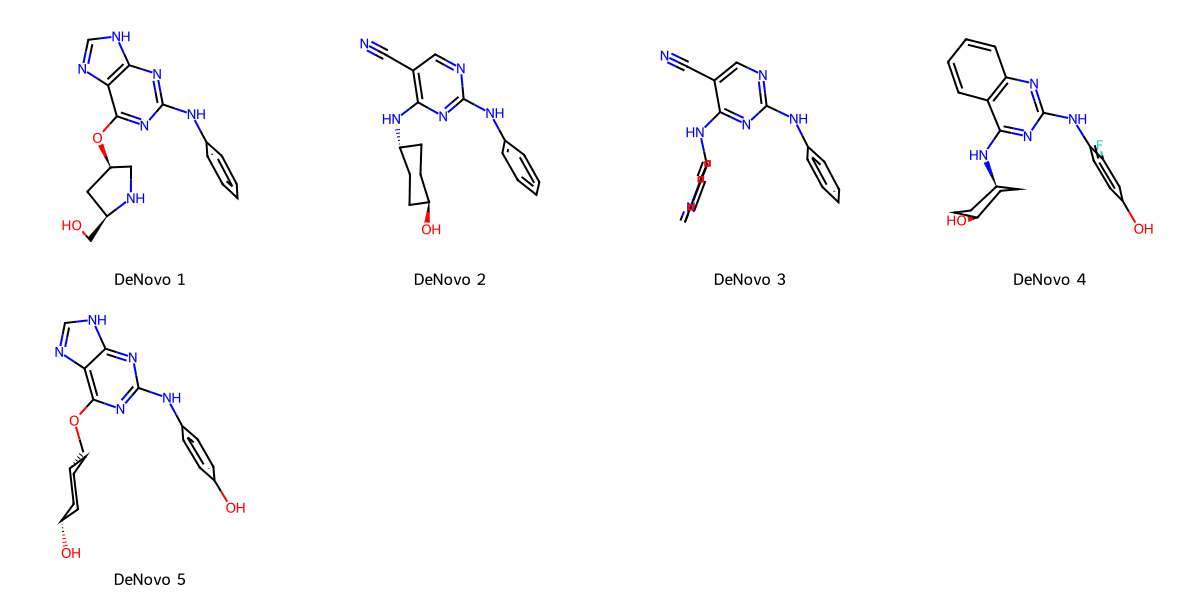

In [12]:
# =============================================================================
# LOAD AND VISUALIZE DE NOVO GENERATED LIGANDS
# =============================================================================

# Find generated SDF files
denovo_sdf_pattern =  "/home/user/flowr_root/out/denovo/*.sdf"
denovo_sdf_files = sorted(glob.glob(str(denovo_sdf_pattern)))

if denovo_sdf_files:
    # Load the generated molecules
    denovo_sdf = denovo_sdf_files[0]  # Take the first/main output file
    denovo_mols = load_molecules_from_sdf(denovo_sdf)
    
    print("\n2D Visualization of De Novo Generated Ligands:")
    display(visualize_molecules_2d(denovo_mols[:8], 
                                   legends=[f"DeNovo {i+1}" for i in range(min(8, len(denovo_mols)))]))
else:
    print("No de novo generated files found. Please run the generation step first.")
    denovo_mols = []

In [13]:
# Visualize a single de novo ligand in 3D (standalone)
idx = 1
if denovo_mols:
    print("3D Visualization of First De Novo Generated Ligand:")
    viewer = visualize_ligand_3d(denovo_mols[idx])
    viewer.show()

3D Visualization of First De Novo Generated Ligand:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [16]:
# Visualize de novo ligands within the protein pocket
if denovo_mols:
    print(f"\nDe Novo Ligands in {TARGET.upper()} Binding Pocket:")
    viewer = visualize_multiple_ligands_in_pocket(denovo_mols[:1], PROTEIN_PDB)
    viewer.show()
elif not PROTEIN_PDB.exists():
    print(f"Protein structure not found at {PROTEIN_PDB}")
    print("The protein file is created during generation.")


De Novo Ligands in PTP1B Binding Pocket:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## 4. Scaffold-Conditional Generation

Scaffold-conditional generation preserves the core molecular scaffold from a reference ligand while generating new substituents and modifications. This is useful for lead optimization.

In [ ]:
# =============================================================================
#                    SCAFFOLD-CONDITIONAL GENERATION
# =============================================================================

SCAFFOLD_SAVE_DIR = SAVE_DIR / "scaffold"
SCAFFOLD_SAVE_DIR.mkdir(parents=True, exist_ok=True)

scaffold_cmd = [
    "python", "-m", "flowr.gen.generate_from_pdb",
    "--pdb_file", str(PROTEIN_PDB),
    "--ligand_file", str(LIGANDS_SDF),
    "--ligand_idx", str(LIGAND_IDX),
    "--arch", "pocket",
    "--pocket_type", "holo",
    "--cut_pocket",
    "--pocket_cutoff", str(POCKET_CUTOFF),
    "--gpus", str(NUM_GPUS),
    "--num_workers", str(NUM_WORKERS),
    "--batch_cost", str(BATCH_COST),
    "--ckpt_path", str(CKPT_PATH),
    "--save_dir", str(SCAFFOLD_SAVE_DIR),
    "--max_sample_iter", "20",
    "--coord_noise_scale", str(COORD_NOISE_STD),
    "--sample_n_molecules_per_target", str(N_MOLECULES),
    "--sample_mol_sizes",
    "--categorical_strategy", "uniform-sample",
    "--filter_valid_unique",
    "--filter_cond_substructure",
    "--filter_diversity",
    "--diversity_threshold", "0.7",
    "--optimize_gen_ligs_hs", # Optimize hydrogens in generated ligands
    # "--optimize_gen_ligs", # Optimize generated ligands (only use if you encounter highly strained structures)
    "--scaffold_inpainting", # <-- Enable scaffold conditioning
]

print("Scaffold-Conditional Generation Configuration:")
print(f"  Reference ligand index: {LIGAND_IDX}")
print(f"  Output: {SCAFFOLD_SAVE_DIR}")

# Show reference ligand
print(f"\n🎯 Reference ligand (index {LIGAND_IDX}) providing the scaffold:")
display(visualize_molecules_2d([ref_mols[LIGAND_IDX]], legends=["Reference"]))

In [ ]:
# Run scaffold-conditional generation
run_command(scaffold_cmd, "Scaffold-Conditional Generation")

## 5. Visualize Scaffold-Conditional Ligands

Let's compare the scaffold-conditional generated ligands with the reference scaffold.

In [ ]:
# =============================================================================
# LOAD AND VISUALIZE SCAFFOLD-CONDITIONAL LIGANDS
# =============================================================================

scaffold_sdf_pattern = SCAFFOLD_SAVE_DIR / "*.sdf"
scaffold_sdf_files = sorted(glob.glob(str(scaffold_sdf_pattern)))

if scaffold_sdf_files:
    scaffold_sdf = scaffold_sdf_files[0]
    scaffold_mols = load_molecules_from_sdf(scaffold_sdf)
    
    # Compare with reference
    comparison_mols = [ref_mols[LIGAND_IDX]] + scaffold_mols[:7]
    comparison_legends = ["Reference"] + [f"Scaffold {i+1}" for i in range(min(7, len(scaffold_mols)))]
    
    print("\nComparison: Reference vs Scaffold-Conditional Generated Ligands:")
    display(visualize_molecules_2d(comparison_mols, legends=comparison_legends))
else:
    print("No scaffold-conditional generated files found.")
    scaffold_mols = []

In [ ]:
# Visualize scaffold-conditional ligands in protein pocket
if scaffold_mols and PROTEIN_PDB.exists():
    print(f"\nScaffold-Conditional Ligands in {TARGET.upper()} Binding Pocket:")
    viewer = visualize_multiple_ligands_in_pocket(scaffold_mols[:5], PROTEIN_PDB)
    viewer.show()

## 6. Functional Group-Conditional Generation

Functional group-conditional generation preserves specific functional groups (e.g., hydrogen bond donors/acceptors, charged groups) from the reference ligand while allowing modification of the molecular scaffold.

In [ ]:
# =============================================================================
#                FUNCTIONAL GROUP-CONDITIONAL GENERATION
# =============================================================================

FUNCGROUP_SAVE_DIR = SAVE_DIR / "funcgroup"
FUNCGROUP_SAVE_DIR.mkdir(parents=True, exist_ok=True)

funcgroup_cmd = [
    "python", "-m", "flowr.gen.generate_from_pdb",
    "--pdb_file", str(PROTEIN_PDB),
    "--ligand_file", str(LIGANDS_SDF),
    "--ligand_idx", str(LIGAND_IDX),
    "--arch", "pocket",
    "--pocket_type", "holo",
    "--cut_pocket",
    "--pocket_cutoff", str(POCKET_CUTOFF),
    "--gpus", str(NUM_GPUS),
    "--num_workers", str(NUM_WORKERS),
    "--batch_cost", str(BATCH_COST),
    "--ckpt_path", str(CKPT_PATH),
    "--save_dir", str(FUNCGROUP_SAVE_DIR),
    "--max_sample_iter", "20",
    "--coord_noise_scale", str(COORD_NOISE_STD),
    "--sample_n_molecules_per_target", str(N_MOLECULES),
    "--sample_mol_sizes",
    "--categorical_strategy", "uniform-sample",
    "--filter_valid_unique",
    "--filter_diversity",
    "--diversity_threshold", "0.7",
    "--optimize_gen_ligs_hs", # Optimize hydrogens in generated ligands
    # "--optimize_gen_ligs", # Optimize generated ligands (only use if you encounter highly strained structures)
    "--filter_cond_substructure",
    "--func_group_inpainting",  # <-- Enable functional group conditioning
]

print("Functional Group-Conditional Generation Configuration:")
print(f"  Reference ligand index: {LIGAND_IDX}")
print(f"  Output: {FUNCGROUP_SAVE_DIR}")

In [ ]:
# Run functional group-conditional generation
run_command(funcgroup_cmd, "Functional Group-Conditional Generation")

## 7. Visualize Functional Group-Conditional Ligands

In [ ]:
# =============================================================================
# LOAD AND VISUALIZE FUNCTIONAL GROUP-CONDITIONAL LIGANDS
# =============================================================================

funcgroup_sdf_pattern = FUNCGROUP_SAVE_DIR / "*.sdf"
funcgroup_sdf_files = sorted(glob.glob(str(funcgroup_sdf_pattern)))

if funcgroup_sdf_files:
    funcgroup_sdf = funcgroup_sdf_files[0]
    funcgroup_mols = load_molecules_from_sdf(funcgroup_sdf)
    
    # Compare with reference
    comparison_mols = [ref_mols[LIGAND_IDX]] + funcgroup_mols[:7]
    comparison_legends = ["Reference"] + [f"FuncGroup {i+1}" for i in range(min(7, len(funcgroup_mols)))]
    
    print("\nComparison: Reference vs Functional Group-Conditional Generated Ligands:")
    display(visualize_molecules_2d(comparison_mols, legends=comparison_legends))
else:
    print("No functional group-conditional generated files found.")
    funcgroup_mols = []

In [ ]:
# Visualize functional group-conditional ligands in protein pocket
if funcgroup_mols and PROTEIN_PDB.exists():
    print(f"\nFunctional Group-Conditional Ligands in {TARGET.upper()} Binding Pocket:")
    viewer = visualize_multiple_ligands_in_pocket(funcgroup_mols[:5], PROTEIN_PDB)
    viewer.show()

## 8. Substructure Inpainting

Substructure inpainting allows you to selectively regenerate specific parts of a molecule while preserving others. This is particularly useful for:
- Optimizing specific regions of a lead compound
- Exploring modifications to particular functional groups
- Maintaining critical binding interactions while varying other parts

In [ ]:
# =============================================================================
#                       SUBSTRUCTURE INPAINTING
# =============================================================================

sub_mol = Chem.RemoveHs(ref_mols[LIGAND_IDX])
# Visualize reference ligand with atom indices
print("🎯  Reference ligand (index {LIGAND_IDX}) with atom indices:")
print(f"   Total heavy atoms: {sub_mol.GetNumHeavyAtoms()}")
print("    Select atom indices below to keep fixed during inpainting.\n")
print("    NOTE: Atom indices need to be taken from the molecule without hydrogens!")

visualize_mol_with_atom_indices(sub_mol)

# Define which atoms to keep fixed (modify based on visualization above!)
FIXED_ATOM_INDICES = [15, 16, 17, 18, 19]  # <-- Adjust these!

INPAINT_SAVE_DIR = SAVE_DIR / "substructure"
INPAINT_SAVE_DIR.mkdir(parents=True, exist_ok=True)

inpaint_cmd = [
    "python", "-m", "flowr.gen.generate_from_pdb",
    "--pdb_file", str(PROTEIN_PDB),
    "--ligand_file", str(LIGANDS_SDF),
    "--ligand_idx", str(LIGAND_IDX),
    "--arch", "pocket",
    "--pocket_type", "holo",
    "--cut_pocket",
    "--pocket_cutoff", str(POCKET_CUTOFF),
    "--gpus", str(NUM_GPUS),
    "--num_workers", str(NUM_WORKERS),
    "--batch_cost", str(BATCH_COST),
    "--ckpt_path", str(CKPT_PATH),
    "--save_dir", str(INPAINT_SAVE_DIR),
    "--max_sample_iter", "20",
    "--coord_noise_scale", str(COORD_NOISE_STD),
    "--sample_n_molecules_per_target", str(N_MOLECULES),
    "--sample_mol_sizes",
    "--categorical_strategy", "uniform-sample",
    "--filter_valid_unique",
    "--filter_diversity",
    "--diversity_threshold", "0.7",
    "--optimize_gen_ligs_hs", # Optimize hydrogens in generated ligands
    # "--optimize_gen_ligs", # Optimize generated ligands (only use if you encounter highly strained structures)
    "--filter_cond_substructure",
    "--substructure_inpainting",  # <-- Enable substructure inpainting
    "--substructure",  # <-- Followed by atom indices
] + [str(idx) for idx in FIXED_ATOM_INDICES]

print("Substructure Inpainting Configuration:")
print(f"  Reference ligand index: {LIGAND_IDX}")
print(f"  Fixed atom indices: {FIXED_ATOM_INDICES}")
print(f"  Output: {INPAINT_SAVE_DIR}")

In [ ]:
# Run substructure inpainting
run_command(inpaint_cmd, "Substructure Inpainting")

## 9. Visualize Inpainted Ligands

When visualizing inpainted ligands, we want to highlight which regions were preserved versus regenerated.

In [ ]:
# =============================================================================
# LOAD AND VISUALIZE INPAINTED LIGANDS
# =============================================================================

inpaint_sdf_pattern = INPAINT_SAVE_DIR / "*.sdf"
inpaint_sdf_files = sorted(glob.glob(str(inpaint_sdf_pattern)))

if inpaint_sdf_files:
    inpaint_sdf = inpaint_sdf_files[0]
    inpaint_mols = load_molecules_from_sdf(inpaint_sdf)
    
    # Compare with reference
    comparison_mols = [ref_mols[LIGAND_IDX]] + inpaint_mols[:7]
    comparison_legends = ["Original"] + [f"Inpainted {i+1}" for i in range(min(7, len(inpaint_mols)))]
    
    print("\nComparison: Original vs Inpainted Ligands:")
    print("(Preserved regions remain similar, inpainted regions show variation)")
    display(visualize_molecules_2d(comparison_mols, legends=comparison_legends))
else:
    print("No inpainted generated files found.")
    inpaint_mols = []

In [ ]:
# Visualize inpainted ligands in protein pocket
if inpaint_mols and PROTEIN_PDB.exists():
    print(f"\nInpainted Ligands in {TARGET.upper()} Binding Pocket:")
    viewer = visualize_multiple_ligands_in_pocket(inpaint_mols[:5], PROTEIN_PDB)
    viewer.show()

## 10. Affinity Prediction

Now let's predict binding affinities for ligands using the flowr.root affinity prediction model. We'll predict affinities for all ligands in the reference SDF file.

In [19]:
# =============================================================================
#                         AFFINITY PREDICTION
# =============================================================================

AFFINITY_SAVE_DIR = "/home/user/flowr_root/out/affinity"

# Affinity prediction parameters (from predict.sh)
AFFINITY_COORD_NOISE = 0.05  # Lower noise for prediction stability
AFFINITY_BATCH_COST = 5
SEED = 42

# Build command based on predict.sh structure
affinity_cmd = [
    "python", "-m", "flowr.predict.predict_from_pdb",
    "--gpus", str(NUM_GPUS),
    "--num_workers", str(NUM_WORKERS),
    "--seed", str(SEED),
    "--batch_cost", str(AFFINITY_BATCH_COST),
    "--arch", "pocket",
    "--pocket_noise", "fix",
    "--pocket_type", "holo",
    "--cut_pocket",
    "--pocket_cutoff", str(POCKET_CUTOFF), 
    "--pdb_file", str(PROTEIN_PDB),
    "--ligand_file", str(LIGANDS_SDF),
    "--multiple_ligands", # <-------- SDF contains multilpe ligands, for which we want to predict affinities; remove if you only have one ligand!
    "--ckpt_path", str(CKPT_PATH),
    "--save_dir", str(AFFINITY_SAVE_DIR),
    "--coord_noise_scale", str(AFFINITY_COORD_NOISE),
]


print("Affinity Prediction Configuration:")
print(f"  Protein: ")
print(f"  Ligands: ")
print("   Architecture: pocket")
print("   Pocket noise: fix")
print(f"  Coord noise scale: {AFFINITY_COORD_NOISE}")
print(f"  Batch cost: {AFFINITY_BATCH_COST}")
print(f"  Seed: {SEED}")
print(f"  Output: {AFFINITY_SAVE_DIR}")

Affinity Prediction Configuration:
  Protein: 
  Ligands: 
   Architecture: pocket
   Pocket noise: fix
  Coord noise scale: 0.05
  Batch cost: 5
  Seed: 42
  Output: /home/user/flowr_root/out/affinity


In [20]:
# Run affinity prediction
run_command(affinity_cmd, "Affinity Prediction")


Running: Affinity Prediction
Command: python -m flowr.predict.predict_from_pdb --gpus 1 --num_workers 12 --seed 42 --batch_cost 5 --arch pocket --pocket_noise fix --pocket_type holo --cut_pocket --pocket_cutoff 6 --pdb_file /home/user/flowr_root/examples/cdk2_protein.pdb --ligand_file /home/user/flowr_root/examples/cdk2_ligands.sdf --multiple_ligands --ckpt_path /home/user/flowr_root_v2.ckpt --save_dir /home/user/flowr_root/out/affinity --coord_noise_scale 0.05
Using model stored at /home/user/flowr_root_v2.ckpt
Loading model...
Building model vocabs...
Vocabs complete.
Loading pretrained checkpoint from /home/user/flowr_root_v2.ckpt...
Done.
Model complete.
Failed to sanitize molecule: Explicit valence for atom # 0 C, 5, is greater than permitted. Returning None and potentially correcting downstream.
Failed to sanitize molecule: Explicit valence for atom # 10 C, 5, is greater than permitted. Returning None and potentially correcting downstream.
Failed to sanitize molecule: Explicit v

CompletedProcess(args=['python', '-m', 'flowr.predict.predict_from_pdb', '--gpus', '1', '--num_workers', '12', '--seed', '42', '--batch_cost', '5', '--arch', 'pocket', '--pocket_noise', 'fix', '--pocket_type', 'holo', '--cut_pocket', '--pocket_cutoff', '6', '--pdb_file', '/home/user/flowr_root/examples/cdk2_protein.pdb', '--ligand_file', '/home/user/flowr_root/examples/cdk2_ligands.sdf', '--multiple_ligands', '--ckpt_path', '/home/user/flowr_root_v2.ckpt', '--save_dir', '/home/user/flowr_root/out/affinity', '--coord_noise_scale', '0.05'], returncode=0, stdout='Using model stored at /home/user/flowr_root_v2.ckpt\nLoading model...\nBuilding model vocabs...\nVocabs complete.\nLoading pretrained checkpoint from /home/user/flowr_root_v2.ckpt...\nDone.\nModel complete.\nFailed to sanitize molecule: Explicit valence for atom # 0 C, 5, is greater than permitted. Returning None and potentially correcting downstream.\nFailed to sanitize molecule: Explicit valence for atom # 10 C, 5, is greater t

In [21]:
# =============================================================================
# LOAD AFFINITY PREDICTIONS
# =============================================================================

def load_affinity_sdf(
    sdf_path: Union[str, Path],
    affinity_props: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Load ligands from SDF file and extract affinity predictions into a DataFrame.
    
    Args:
        sdf_path: Path to the SDF file with affinity properties
        affinity_props: List of affinity property names to extract. 
                       Defaults to ["pIC50", "pKd", "pKi", "pEC50"]
    
    Returns:
        DataFrame with ligand index, SMILES, and affinity predictions
    """
    if affinity_props is None:
        affinity_props = ["pic50", "pkd", "pki", "pec50"]
    
    sdf_path = Path(sdf_path)
    if not sdf_path.exists():
        raise FileNotFoundError(f"SDF file not found: {sdf_path}")
    
    suppl = Chem.SDMolSupplier(str(sdf_path), removeHs=False)
    mols = [mol for mol in suppl if mol is not None]
    
    data = {
        "ligand_idx": list(range(len(mols))),
        "smiles": [Chem.MolToSmiles(mol) for mol in mols],
    }
    
    for prop in affinity_props:
        values = []
        for mol in mols:
            if mol.HasProp(prop):
                try:
                    values.append(float(mol.GetProp(prop)))
                except ValueError:
                    values.append(np.nan)
            else:
                values.append(np.nan)
        data[prop] = values
    
    return pd.DataFrame(data)

# Load
sdf_path = f"{AFFINITY_SAVE_DIR}/gen_lig_with_aff.sdf"
affinity_df = load_affinity_sdf(sdf_path)
print(affinity_df)

   ligand_idx                                        smiles    pic50  \
0           0  C1=CC[C@H](Nc2nc(OCC3CCCCC3)c3nc[nH]c3n2)CC1  6.10624   

        pkd      pki     pec50  
0  5.690157  6.14416  6.239625  


## 11. Visualize Affinity Predictions

Let's create comprehensive visualizations of the predicted binding affinities.

✓ Figure saved to /home/user/flowr_root/out/affinity/affinity_analysis_pic50.png


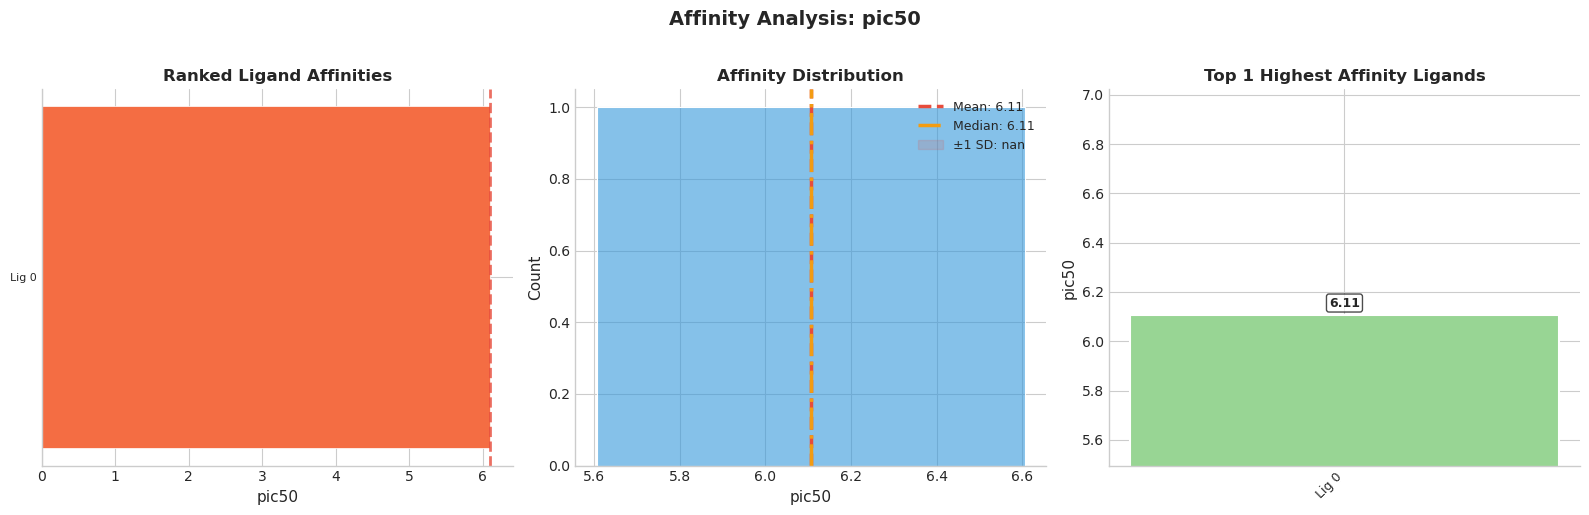


  pic50 Summary Statistics
  Count:    1
  Mean:     6.106
  Std:      nan
  Min:      6.106
  25%:      6.106
  Median:   6.106
  75%:      6.106
  Max:      6.106



In [22]:
# =============================================================================
# AFFINITY VISUALIZATION
# =============================================================================

AFFINITY_TYPE = "pic50" # Choose from "pic50", "pkd", "pki", "pec50"

def visualize_affinity(
    affinity_df: pd.DataFrame,
    affinity_type: str = "pic50",
    save_dir: Optional[Union[str, Path]] = None,
    figsize: tuple = (16, 5),
    top_n: int = 10,
    dpi: int = 300,
    show_plot: bool = True,
) -> plt.Figure:
    """
    Visualize affinity predictions with publication-quality figures.
    
    Args:
        affinity_df: DataFrame with ligand data and affinity predictions
        affinity_type: Which affinity type to visualize ("pIC50", "pKd", "pKi", "pEC50")
        save_dir: Directory to save the figure (optional)
        figsize: Figure size (width, height)
        top_n: Number of top ligands to highlight
        dpi: Resolution for saved figure
        show_plot: Whether to display the plot
    
    Returns:
        matplotlib Figure object
    """
    # Validate affinity type exists in dataframe
    if affinity_type not in affinity_df.columns:
        available = [col for col in ["pic50", "pkd", "pki", "pec50"] if col in affinity_df.columns]
        raise ValueError(f"Affinity type '{affinity_type}' not found. Available: {available}")
    
    # Filter out NaN values for the selected affinity type
    df = affinity_df.dropna(subset=[affinity_type]).copy()
    
    if len(df) == 0:
        raise ValueError(f"No valid data for affinity type '{affinity_type}'")
    
    # Set up color palette
    palette = {
        "pIC50": "#2ecc71",
        "pKd": "#3498db", 
        "pKi": "#9b59b6",
        "pEC50": "#e74c3c"
    }
    main_color = palette.get(affinity_type, "#3498db")
    
    # Create figure with custom styling
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f"Affinity Analysis: {affinity_type}", fontsize=14, fontweight='bold', y=1.02)
    
    # Calculate statistics
    mean_val = df[affinity_type].mean()
    median_val = df[affinity_type].median()
    std_val = df[affinity_type].std()
    
    # =========================================================================
    # Plot 1: Ranked Ligand Affinities (Horizontal Bar Plot)
    # =========================================================================
    ax1 = axes[0]
    sorted_df = df.sort_values(affinity_type, ascending=True)
    
    # Limit number of bars for readability
    max_bars = min(30, len(sorted_df))
    plot_df = sorted_df.tail(max_bars) if len(sorted_df) > max_bars else sorted_df
    
    # Create gradient colors based on values
    norm_vals = (plot_df[affinity_type] - plot_df[affinity_type].min()) / \
                (plot_df[affinity_type].max() - plot_df[affinity_type].min() + 1e-8)
    colors = plt.cm.RdYlGn(0.2 + 0.6 * norm_vals.values)
    
    y_pos = range(len(plot_df))
    bars = ax1.barh(y_pos, plot_df[affinity_type], color=colors, edgecolor='white', linewidth=0.5)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([f"Lig {i}" for i in plot_df['ligand_idx']], fontsize=8)
    ax1.set_xlabel(f'{affinity_type}', fontsize=11)
    ax1.set_title('Ranked Ligand Affinities', fontsize=12, fontweight='bold')
    
    # Add mean line with annotation
    ax1.axvline(x=mean_val, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.8)
    ax1.annotate(f'μ = {mean_val:.2f}', xy=(mean_val, len(plot_df) * 0.95), 
                 fontsize=9, color='#e74c3c', fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # =========================================================================
    # Plot 2: Distribution with KDE
    # =========================================================================
    ax2 = axes[1]
    
    # Histogram with KDE
    sns.histplot(df[affinity_type], bins='auto', kde=True, color=main_color, 
                 alpha=0.6, edgecolor='white', linewidth=0.8, ax=ax2)
    
    # Add statistical lines
    ax2.axvline(x=mean_val, color='#e74c3c', linestyle='--', linewidth=2.5, 
                label=f'Mean: {mean_val:.2f}')
    ax2.axvline(x=median_val, color='#f39c12', linestyle='-.', linewidth=2.5, 
                label=f'Median: {median_val:.2f}')
    
    # Add std deviation band
    ax2.axvspan(mean_val - std_val, mean_val + std_val, alpha=0.15, color='#e74c3c',
                label=f'±1 SD: {std_val:.2f}')
    
    ax2.set_xlabel(f'{affinity_type}', fontsize=11)
    ax2.set_ylabel('Count', fontsize=11)
    ax2.set_title('Affinity Distribution', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=9, framealpha=0.9)
    
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # =========================================================================
    # Plot 3: Top N Ligands
    # =========================================================================
    ax3 = axes[2]
    top_n_actual = min(top_n, len(df))
    top_ligands = df.nlargest(top_n_actual, affinity_type)
    
    # Create gradient for top ligands
    top_colors = plt.cm.Greens(np.linspace(0.4, 0.9, top_n_actual))[::-1]
    
    x_pos = range(top_n_actual)
    bars = ax3.bar(x_pos, top_ligands[affinity_type], color=top_colors, 
                   edgecolor='white', linewidth=1.5, width=0.7)
    
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([f"Lig {i}" for i in top_ligands['ligand_idx']], 
                        fontsize=9, rotation=45, ha='right')
    ax3.set_ylabel(f'{affinity_type}', fontsize=11)
    ax3.set_title(f'Top {top_n_actual} Highest Affinity Ligands', fontsize=12, fontweight='bold')
    
    # Add value labels on bars
    for bar, val in zip(bars, top_ligands[affinity_type]):
        height = bar.get_height()
        ax3.annotate(f'{val:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 4), textcoords="offset points",
                     ha='center', va='bottom', fontsize=9, fontweight='bold',
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    # Add padding at top for labels
    y_max = top_ligands[affinity_type].max()
    y_min = top_ligands[affinity_type].min()
    ax3.set_ylim(y_min - 0.1 * abs(y_min), y_max * 1.15)
    
    # =========================================================================
    # Finalize
    # =========================================================================
    plt.tight_layout()
    
    # Save figure
    if save_dir is not None:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        save_path = save_dir / f'affinity_analysis_{affinity_type}.png'
        fig.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"✓ Figure saved to {save_path}")
    
    if show_plot:
        plt.show()
    
    return fig


def visualize_all_affinities(
    affinity_df: pd.DataFrame,
    save_dir: Optional[Union[str, Path]] = None,
    **kwargs
) -> dict:
    """
    Generate visualizations for all available affinity types.
    
    Args:
        affinity_df: DataFrame with ligand data and affinity predictions
        save_dir: Directory to save figures
        **kwargs: Additional arguments passed to visualize_affinity
    
    Returns:
        Dictionary mapping affinity type to Figure object
    """
    affinity_types = ["pIC50", "pKd", "pKi", "pEC50"]
    available = [t for t in affinity_types if t in affinity_df.columns 
                 and affinity_df[t].notna().any()]
    
    figures = {}
    for aff_type in available:
        try:
            fig = visualize_affinity(affinity_df, aff_type, save_dir, **kwargs)
            figures[aff_type] = fig
        except ValueError as e:
            print(f"⚠ Skipping {aff_type}: {e}")
    
    return figures


def print_affinity_summary(affinity_df: pd.DataFrame, affinity_type: str = "pic50"):
    """Print summary statistics for the specified affinity type."""
    if affinity_type not in affinity_df.columns:
        print(f"⚠ {affinity_type} not found in dataframe")
        return
    
    values = affinity_df[affinity_type].dropna()
    
    print(f"\n{'='*50}")
    print(f"  {affinity_type} Summary Statistics")
    print(f"{'='*50}")
    print(f"  Count:    {len(values)}")
    print(f"  Mean:     {values.mean():.3f}")
    print(f"  Std:      {values.std():.3f}")
    print(f"  Min:      {values.min():.3f}")
    print(f"  25%:      {values.quantile(0.25):.3f}")
    print(f"  Median:   {values.median():.3f}")
    print(f"  75%:      {values.quantile(0.75):.3f}")
    print(f"  Max:      {values.max():.3f}")
    print(f"{'='*50}\n")


# Load data
sdf_path = f"{AFFINITY_SAVE_DIR}/gen_lig_with_aff.sdf"
affinity_df = load_affinity_sdf(sdf_path)

# Visualize single affinity type
visualize_affinity(affinity_df, affinity_type=AFFINITY_TYPE, save_dir=AFFINITY_SAVE_DIR)

# Print summary
print_affinity_summary(affinity_df, AFFINITY_TYPE)

# Visualize all available affinity types
figures = visualize_all_affinities(affinity_df, save_dir=AFFINITY_SAVE_DIR, show_plot=False)

In [ ]:
# =============================================================================
# VISUALIZE TOP PREDICTED LIGANDS
# =============================================================================

def visualize_top_ligands_2d(
    affinity_df: pd.DataFrame,
    mols: list,
    affinity_type: str = "pic50",
    top_n: int = 4,
    mols_per_row: int = 4,
) -> Optional[object]:
    """
    Show 2D structures of top-affinity ligands.
    
    Args:
        affinity_df: DataFrame with ligand data and affinity predictions
        mols: List of RDKit molecule objects
        affinity_type: Which affinity type to use for ranking
        top_n: Number of top ligands to display
        mols_per_row: Number of molecules per row in the grid
    
    Returns:
        Visualization object from visualize_fn, or None if no molecules
    """
    if not mols or len(affinity_df) == 0:
        print("⚠ No molecules or affinity data available")
        return None
    
    if affinity_type not in affinity_df.columns:
        available = [col for col in ["pIC50", "pKd", "pKi", "pEC50"] if col in affinity_df.columns]
        raise ValueError(f"Affinity type '{affinity_type}' not found. Available: {available}")
    
    # Filter valid entries and get top N
    valid_df = affinity_df.dropna(subset=[affinity_type])
    top_df = valid_df.nlargest(min(top_n, len(valid_df)), affinity_type)
    
    top_indices = top_df['ligand_idx'].values.astype(int)
    top_affinities = top_df[affinity_type].values
    
    # Get corresponding molecules
    top_mols = [mols[i] for i in top_indices if i < len(mols)]
    
    if not top_mols:
        print("⚠ No valid molecules found for top indices")
        return None
    
    # Create legends with affinity type and values
    legends = [
        f"Ligand {idx}\n{affinity_type}: {aff:.2f}" 
        for idx, aff in zip(top_indices, top_affinities)
    ]
    
    print(f"\nTop {len(top_mols)} Predicted Ligands (Highest {affinity_type}):")
    
    from rdkit.Chem import Draw
    img = Draw.MolsToGridImage(
        top_mols, 
        molsPerRow=mols_per_row, 
        subImgSize=(300, 300),
        legends=legends
    )
    return img


# With RDKit default (no custom function needed)
img = visualize_top_ligands_2d(
    affinity_df=affinity_df,
    mols=ref_mols,
    affinity_type=AFFINITY_TYPE,
    top_n=6,
    mols_per_row=3
)
display(img)

In [ ]:
# =============================================================================
# CLEANUP AND FINAL NOTES
# =============================================================================

print("\n" + "="*60)
print("TUTORIAL COMPLETE")
print("="*60)
print(f"\nAll outputs saved to: {SAVE_DIR}")
print("\nGenerated directories:")
for subdir in ['denovo', 'scaffold', 'funcgroup', 'substructure', 'affinity']:
    subdir_path = SAVE_DIR / subdir
    if subdir_path.exists():
        print(f"  ✓ {subdir_path}")
    else:
        print(f"  ○ {subdir_path} (run generation to create)")

print("\n" + "="*60)